# Neural network 6 emotions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, callbacks, activations, regularizers
import numpy as np

2023-06-19 17:23:51.274142: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
def plot_results(hist):
  fig, axs = plt.subplots(1, 2, figsize=(25, 8))
  axs[0].plot(hist.history['loss'], label='loss')
  axs[0].plot(hist.history['val_loss'], label='val_loss')
  axs[1].plot(hist.history['accuracy'], label='accuracy')
  axs[1].plot(hist.history['val_accuracy'], label='val_accuracy')

  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('Loss')
  axs[0].legend()
  axs[0].grid(True)

  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('Accuracy')
  axs[1].legend()
  axs[1].grid(True)

Load and scale data
Change labels to numerical values
Remove highly correlated features
Create train, validation and test splits

In [4]:
# loading the data
dataset = pd.read_csv('../dataset/labeled_6_combined_dataset.csv', index_col=0)

# getting unique labels
unique_labels = np.unique(dataset['LABEL'])
unique_labels

array(['Ekscytacja', 'Neutralna', 'Odprezenie', 'Radosc', 'Smutek',
       'Zlosc'], dtype=object)

In [5]:
# changing labels to numerical
dataset.loc[dataset['LABEL'] == 'Ekscytacja', 'LABEL'] = 0.0
dataset.loc[dataset['LABEL'] == 'Neutralna', 'LABEL'] = 1.0
dataset.loc[dataset['LABEL'] == 'Odprezenie', 'LABEL'] = 2.0
dataset.loc[dataset['LABEL'] == 'Radosc', 'LABEL'] = 3.0
dataset.loc[dataset['LABEL'] == 'Smutek', 'LABEL'] = 4.0
dataset.loc[dataset['LABEL'] == 'Zlosc', 'LABEL'] = 5.0

In [6]:
# separating data and labels
data = dataset.iloc[:, :-4]
labels = dataset.iloc[:, -1]
labels = np.asarray(labels).astype('float32')

# scaling the data
data_scaled = StandardScaler().fit_transform(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)

# creating train, validation and test splits
d, data_test, l, labels_test = train_test_split(data_scaled, labels, test_size=0.1, random_state=0, stratify=labels)
data_train, data_validation, labels_train, labels_validation = train_test_split(d, l, test_size=0.1, random_state=0, stratify=l)

In [7]:
BaseDense = partial(
    layers.Dense,
    kernel_initializer="he_normal",
    kernel_regularizer=tf.keras.regularizers.l2(0.001),
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=96, restore_best_weights=True)
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=32)

# ECG

Extract only ecg related features

In [8]:
ecg_columns = [col for col in data.columns if 'ECG' in col or 'HRV' in col]

ecg_data_train = data_train[ecg_columns]
ecg_data_validation = data_validation[ecg_columns]
ecg_data_test = data_test[ecg_columns]

Define the model and train it

Epoch 1/1000


2023-06-19 17:23:52.843351: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-19 17:23:53.364444: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3353 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1
2023-06-19 17:23:54.275656: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7efaf40105a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-19 17:23:54.275685: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2023-06-19 17:23:54.340454: I tensorflow/compile

134/134 [==============================] - 2s 4ms/step - loss: 3.0958 - accuracy: 0.2338 - val_loss: 2.7252 - val_accuracy: 0.2397 - lr: 0.1000
Epoch 2/1000
134/134 [==============================] - 0s 3ms/step - loss: 2.5051 - accuracy: 0.2419 - val_loss: 2.3222 - val_accuracy: 0.2419 - lr: 0.1000
Epoch 3/1000
134/134 [==============================] - 0s 3ms/step - loss: 2.1916 - accuracy: 0.2457 - val_loss: 2.0882 - val_accuracy: 0.2450 - lr: 0.1000
Epoch 4/1000
134/134 [==============================] - 0s 3ms/step - loss: 2.0087 - accuracy: 0.2483 - val_loss: 1.9552 - val_accuracy: 0.2345 - lr: 0.1000
Epoch 5/1000
134/134 [==============================] - 0s 3ms/step - loss: 1.9028 - accuracy: 0.2498 - val_loss: 1.8699 - val_accuracy: 0.2440 - lr: 0.1000
Epoch 6/1000
134/134 [==============================] - 0s 3ms/step - loss: 1.8419 - accuracy: 0.2513 - val_loss: 1.8211 - val_accuracy: 0.2471 - lr: 0.1000
Epoch 7/1000
134/134 [==============================] - 0s 3ms/step - l

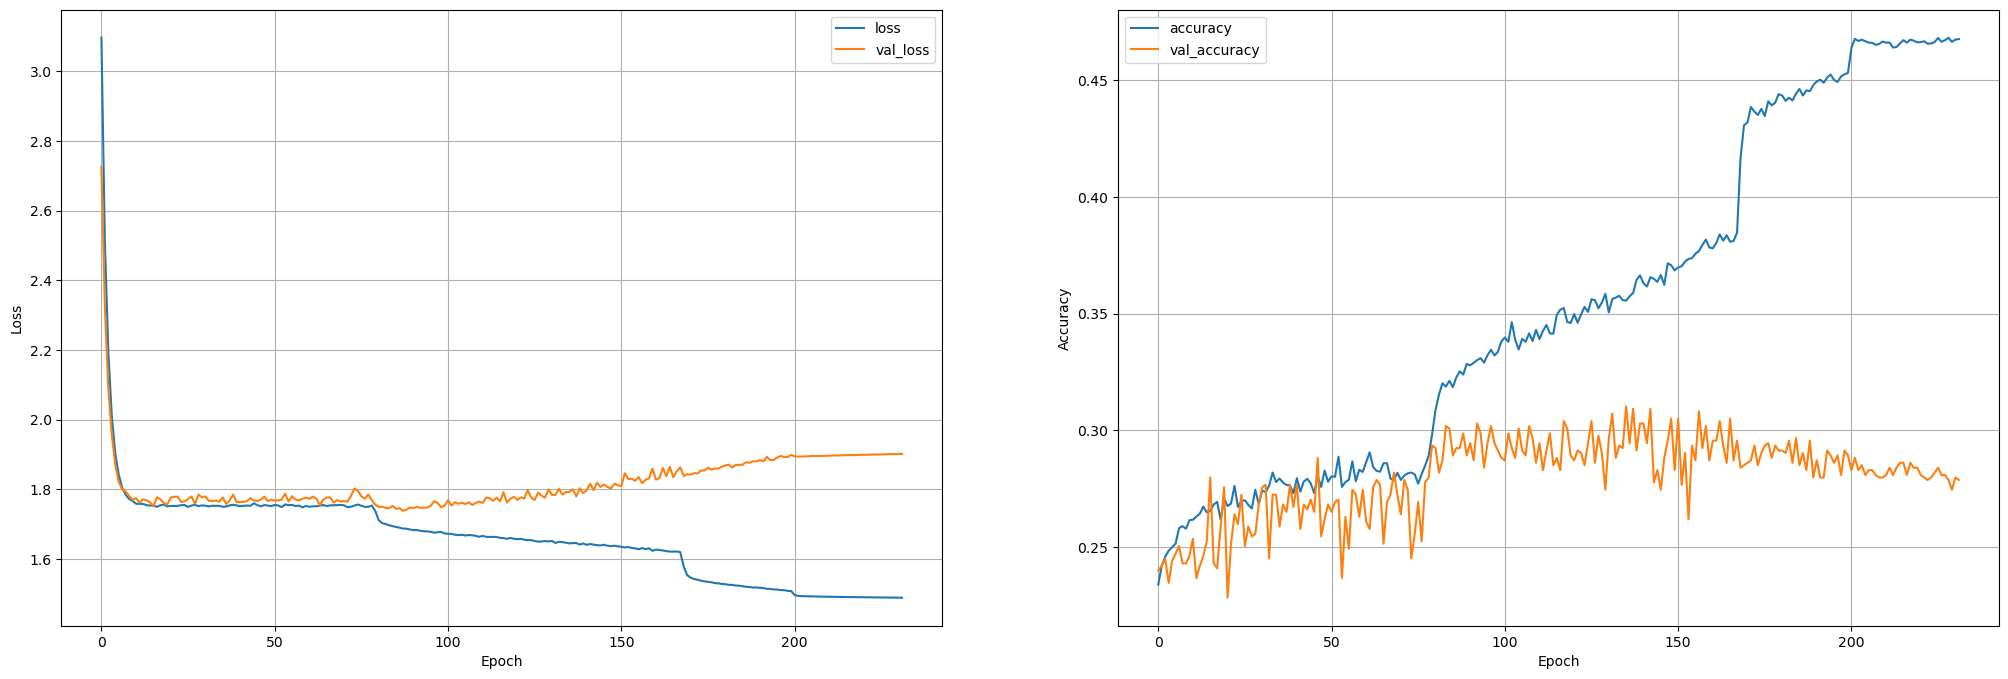

In [9]:
ecg_model = tf.keras.Sequential([
    BaseDense(256),
    layers.ReLU(),
    BaseDense(256),
    layers.ReLU(),
    BaseDense(256),
    layers.ReLU(),
    layers.Dense(6, activation='softmax')
])

ecg_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

h = ecg_model.fit(
    ecg_data_train,
    labels_train,
    epochs=1000,
    batch_size=64,
    validation_data=(ecg_data_validation, labels_validation),
    callbacks=[early_stop, reduce_lr_cb]
)

plot_results(h)

In [10]:
ecg_predictions = np.argmax(ecg_model.predict(ecg_data_test), axis=1)

ecg_cr = classification_report(labels_test, ecg_predictions, target_names=unique_labels, zero_division=0, digits=4, output_dict=True)
print(classification_report(labels_test, ecg_predictions, target_names=unique_labels, zero_division=0, digits=4))

34/34 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

  Ekscytacja     0.1471    0.0413    0.0645       121
   Neutralna     0.3634    0.5529    0.4386       255
  Odprezenie     0.1795    0.1419    0.1585       148
      Radosc     0.2000    0.0819    0.1162       171
      Smutek     0.1562    0.0336    0.0552       149
       Zlosc     0.2788    0.5446    0.3688       213

    accuracy                         0.2857      1057
   macro avg     0.2208    0.2327    0.2003      1057
weighted avg     0.2402    0.2857    0.2363      1057



# EDA

Extract only eda related features

In [11]:
eda_columns = [col for col in data.columns if 'EDA' in col or 'SCR' in col]

eda_data_train = data_train[eda_columns]
eda_data_validation = data_validation[eda_columns]
eda_data_test = data_test[eda_columns]

Define the model and train it

Epoch 1/1000
134/134 [==============================] - 1s 4ms/step - loss: 3.1074 - accuracy: 0.2297 - val_loss: 2.7181 - val_accuracy: 0.2419 - lr: 0.1000
Epoch 2/1000
134/134 [==============================] - 0s 3ms/step - loss: 2.4991 - accuracy: 0.2421 - val_loss: 2.3104 - val_accuracy: 0.2450 - lr: 0.1000
Epoch 3/1000
134/134 [==============================] - 0s 3ms/step - loss: 2.1814 - accuracy: 0.2426 - val_loss: 2.0748 - val_accuracy: 0.2397 - lr: 0.1000
Epoch 4/1000
134/134 [==============================] - 0s 3ms/step - loss: 2.0003 - accuracy: 0.2359 - val_loss: 1.9395 - val_accuracy: 0.2450 - lr: 0.1000
Epoch 5/1000
134/134 [==============================] - 0s 3ms/step - loss: 1.8940 - accuracy: 0.2401 - val_loss: 1.8623 - val_accuracy: 0.2524 - lr: 0.1000
Epoch 6/1000
134/134 [==============================] - 0s 3ms/step - loss: 1.8354 - accuracy: 0.2404 - val_loss: 1.8117 - val_accuracy: 0.2282 - lr: 0.1000
Epoch 7/1000
134/134 [==============================] - 0s

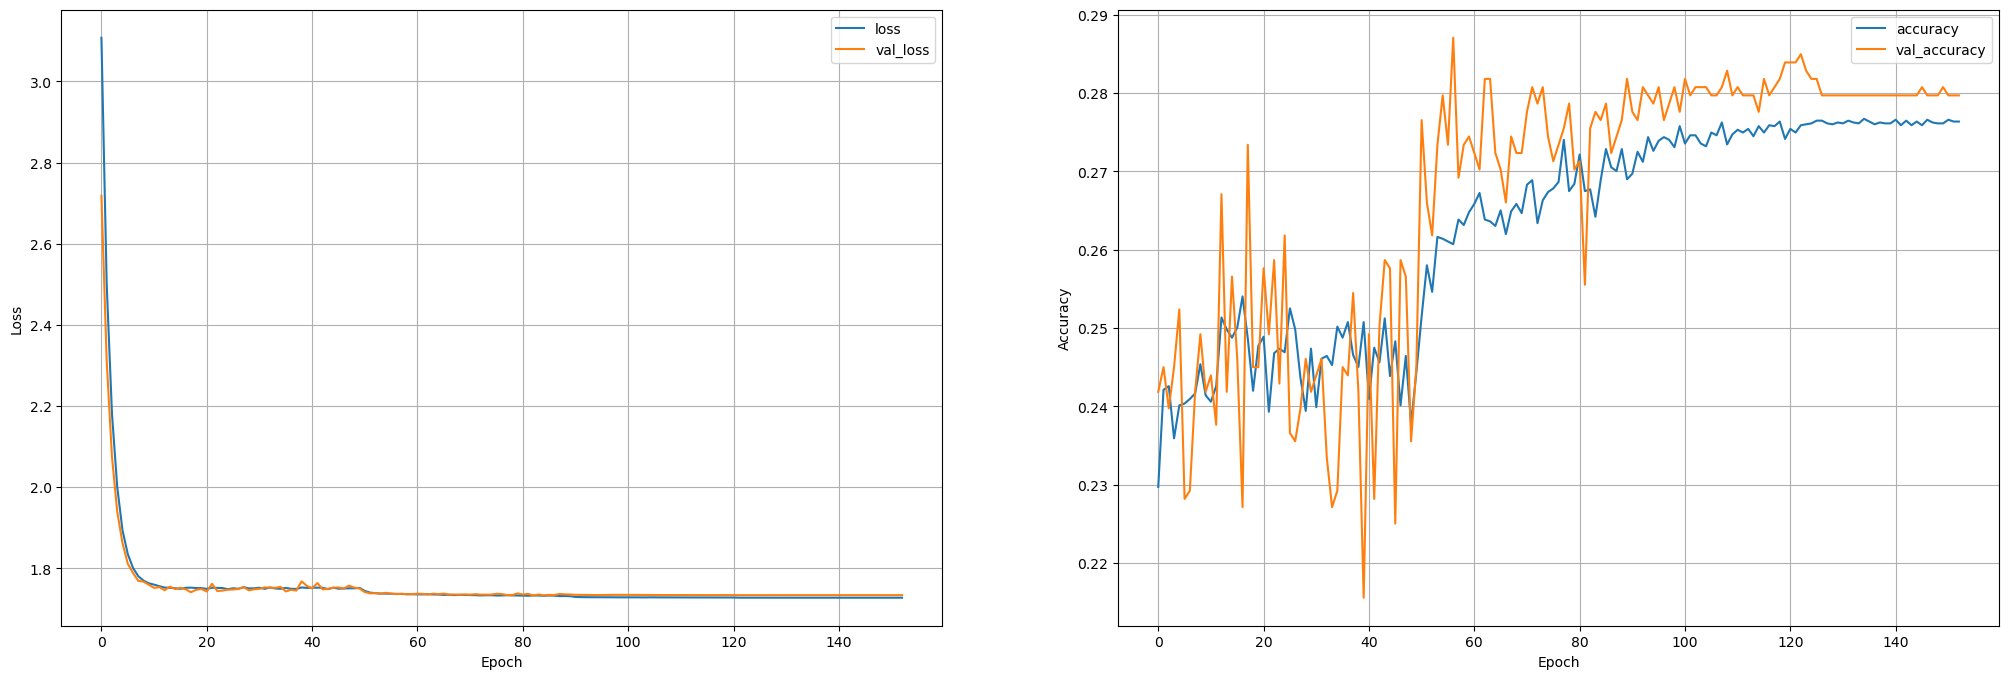

In [12]:
eda_model = tf.keras.Sequential([
    BaseDense(256),
    layers.ReLU(),
    BaseDense(256),
    layers.ReLU(),
    BaseDense(256),
    layers.ReLU(),
    layers.Dense(6, activation='softmax')
])

eda_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

h = eda_model.fit(
    eda_data_train,
    labels_train,
    epochs=1000,
    batch_size=64,
    validation_data=(eda_data_validation, labels_validation),
    callbacks=[early_stop, reduce_lr_cb]
)

plot_results(h)

In [13]:
eda_predictions = np.argmax(eda_model.predict(eda_data_test), axis=1)

eda_cr = classification_report(labels_test, eda_predictions, target_names=unique_labels, zero_division=0, digits=4, output_dict=True)
print(classification_report(labels_test, eda_predictions, target_names=unique_labels, zero_division=0, digits=4))

34/34 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

  Ekscytacja     0.0000    0.0000    0.0000       121
   Neutralna     0.2803    0.6706    0.3954       255
  Odprezenie     0.3704    0.0676    0.1143       148
      Radosc     0.0789    0.0175    0.0287       171
      Smutek     0.0000    0.0000    0.0000       149
       Zlosc     0.2435    0.4366    0.3126       213

    accuracy                         0.2621      1057
   macro avg     0.1622    0.1987    0.1418      1057
weighted avg     0.1813    0.2621    0.1790      1057



# Combined

Epoch 1/1000
134/134 [==============================] - 1s 4ms/step - loss: 3.1646 - accuracy: 0.2335 - val_loss: 2.7525 - val_accuracy: 0.2471 - lr: 0.1000
Epoch 2/1000
134/134 [==============================] - 0s 3ms/step - loss: 2.5254 - accuracy: 0.2432 - val_loss: 2.3383 - val_accuracy: 0.2513 - lr: 0.1000
Epoch 3/1000
134/134 [==============================] - 0s 3ms/step - loss: 2.1942 - accuracy: 0.2577 - val_loss: 2.0854 - val_accuracy: 0.2629 - lr: 0.1000
Epoch 4/1000
134/134 [==============================] - 0s 3ms/step - loss: 2.0044 - accuracy: 0.2636 - val_loss: 1.9386 - val_accuracy: 0.2734 - lr: 0.1000
Epoch 5/1000
134/134 [==============================] - 0s 3ms/step - loss: 1.8944 - accuracy: 0.2664 - val_loss: 1.8596 - val_accuracy: 0.2671 - lr: 0.1000
Epoch 6/1000
134/134 [==============================] - 0s 3ms/step - loss: 1.8343 - accuracy: 0.2752 - val_loss: 1.8242 - val_accuracy: 0.2808 - lr: 0.1000
Epoch 7/1000
134/134 [==============================] - 0s

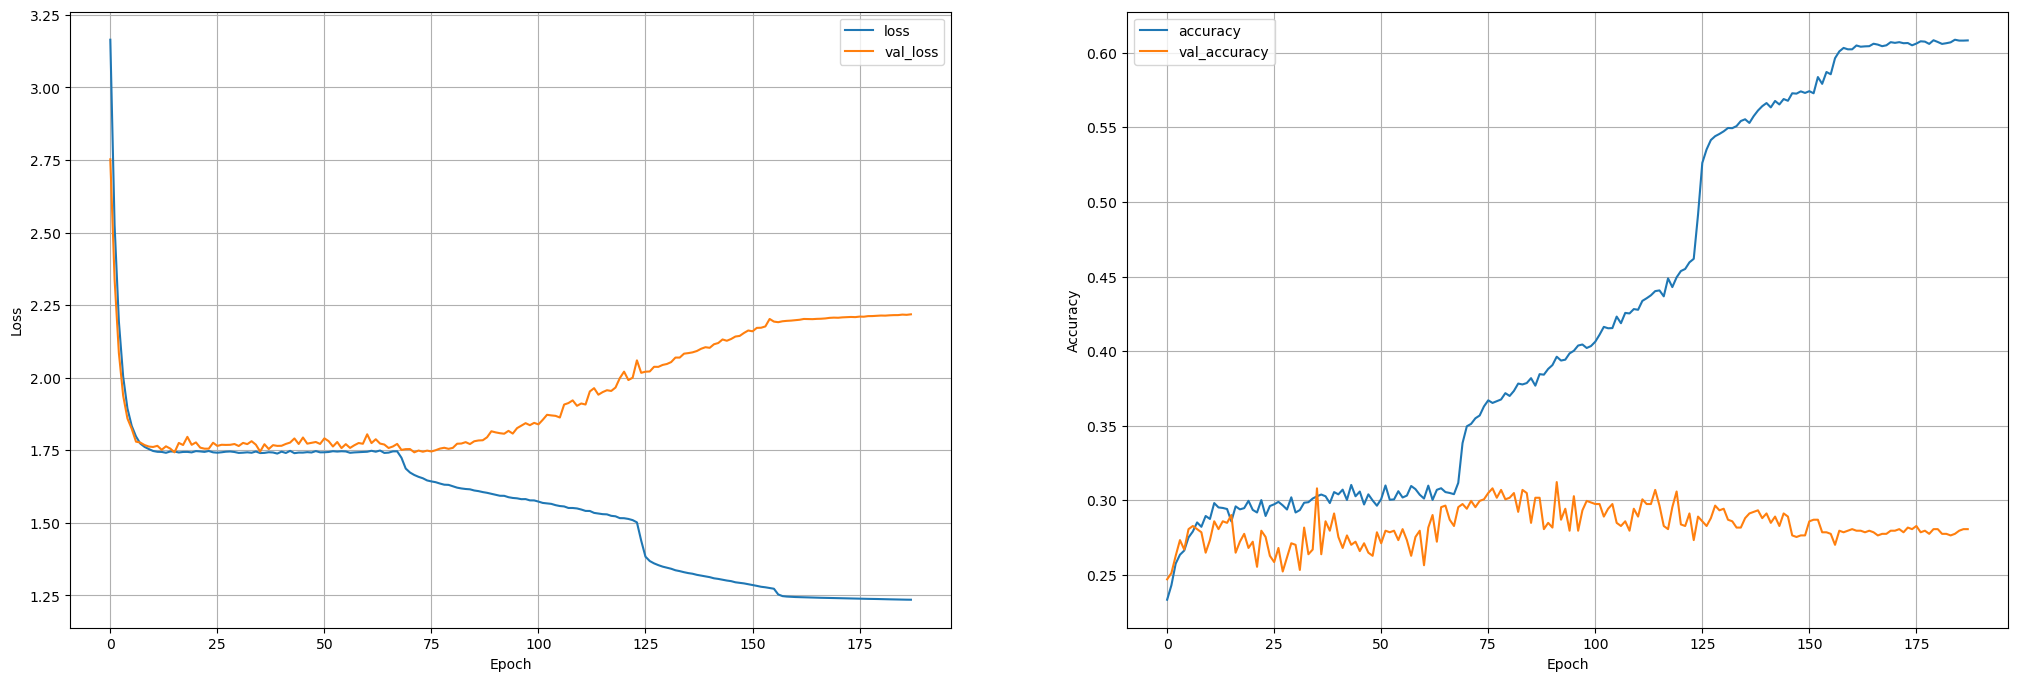

In [14]:
model = tf.keras.Sequential([
    BaseDense(256),
    layers.ReLU(),
    BaseDense(256),
    layers.ReLU(),
    BaseDense(256),
    layers.ReLU(),
    layers.Dense(6, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

h = model.fit(
    data_train,
    labels_train,
    epochs=1000,
    batch_size=64,
    validation_data=(data_validation, labels_validation),
    callbacks=[early_stop, reduce_lr_cb]
)

plot_results(h)

In [15]:
predictions = np.argmax(model.predict(data_test), axis=1)

cr = classification_report(labels_test, predictions, target_names=unique_labels, zero_division=0, digits=4, output_dict=True)
print(classification_report(labels_test, predictions, target_names=unique_labels, zero_division=0, digits=4))

34/34 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

  Ekscytacja     0.2941    0.0826    0.1290       121
   Neutralna     0.3698    0.5569    0.4444       255
  Odprezenie     0.2571    0.1216    0.1651       148
      Radosc     0.1863    0.1111    0.1392       171
      Smutek     0.1714    0.0805    0.1096       149
       Zlosc     0.2897    0.5399    0.3770       213

    accuracy                         0.2990      1057
   macro avg     0.2614    0.2488    0.2274      1057
weighted avg     0.2716    0.2990    0.2591      1057



# Summary

In [16]:
print(f'''
  Accuracy:
ECG:\t{ecg_cr['accuracy']:.4f}
EDA:\t{eda_cr['accuracy']:.4f}
Both:\t{cr['accuracy']:.4f}
  Average F1:
ECG:\t{ecg_cr['macro avg']['f1-score']:.4f}
EDA:\t{eda_cr['macro avg']['f1-score']:.4f}
Both:\t{cr['macro avg']['f1-score']:.4f}
  Weighted F1:
ECG:\t{ecg_cr['weighted avg']['f1-score']:.4f}
EDA:\t{eda_cr['weighted avg']['f1-score']:.4f}
Both:\t{cr['weighted avg']['f1-score']:.4f}
''')


  Accuracy:
ECG:	0.2857
EDA:	0.2621
Both:	0.2990
  Average F1:
ECG:	0.2003
EDA:	0.1418
Both:	0.2274
  Weighted F1:
ECG:	0.2363
EDA:	0.1790
Both:	0.2591

